<a href="https://colab.research.google.com/github/tarushi1/TraffiGuard/blob/main/VehicleIdentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 # open-cv used for image processing
%matplotlib inline
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
import tensorflow_hub as hub
import keras.utils as image
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report

In [3]:
!ls "/content/drive/My Drive"


 1.gsheet
'Attendance Blockchain.gsheet'
'Chemistry Formula Handbook by Competishun.gdoc'
'Colab Notebooks'
'Copy of international_matches.csv'
'Copy of JEE 2023 TIMETABLE - Copy.xlsx'
'Copy of JEE 8 weeks timetable Neha mam - Copy.xlsx'
'Copy of JEE 8 weeks timetable Neha mam.xlsx'
'Copy of NIT'\''s : Rank vs Branch vs College (1).gsheet'
"Copy of NIT's : Rank vs Branch vs College.gsheet"
'Event Name: Act for Impact: The SDG Charades Challenge.gdoc'
 EXPO.gdoc
'Hexathon 2023 (2).docx'
'ios fusion 7.0 brochure modified.gdoc'
'ios fusion timeline .gsheet'
'Local Vendors For Riviera Sponsorship.gdoc'
'Participants contact info.gdoc'
 Planner.gsheet
'riviera event flow.gdoc'
'Schedule (1).gsheet'
'Schedule (2).gsheet'
'Schedule (3).gsheet'
 Schedule.gsheet
'THERMODYNAMICS CRASH COURSE (2) (1).gdoc'
'THERMODYNAMICS CRASH COURSE (2) (2).gdoc'
'THERMODYNAMICS CRASH COURSE (2).gdoc'
'To-do list.gsheet'
'TraffiGuard: AI-Powered Smart Traffic Control (1).gdoc'
'TraffiGuard: AI-Powered Smart Tra

In [6]:
!ls "/content/drive/My Drive/Colab Notebooks/Emergency_Vehicles/test"


1000.jpg  1110.jpg  121.jpg   1311.jpg	1395.jpg  1513.jpg  163.jpg   1737.jpg	1848.jpg  1947.jpg
1001.jpg  1112.jpg  1220.jpg  1313.jpg	1398.jpg  1521.jpg  1640.jpg  173.jpg	184.jpg   1949.jpg
1004.jpg  111.jpg   1222.jpg  1315.jpg	13.jpg	  1523.jpg  1644.jpg  1740.jpg	1852.jpg  1950.jpg
100.jpg   1121.jpg  1223.jpg  1316.jpg	1403.jpg  1525.jpg  1645.jpg  1743.jpg	185.jpg   1952.jpg
1014.jpg  1125.jpg  1229.jpg  1318.jpg	1405.jpg  1530.jpg  1646.jpg  1744.jpg	1861.jpg  1960.jpg
1017.jpg  1127.jpg  1232.jpg  1320.jpg	1406.jpg  1532.jpg  1647.jpg  1745.jpg	1864.jpg  1962.jpg
1025.jpg  1128.jpg  1237.jpg  1321.jpg	1411.jpg  1535.jpg  1651.jpg  1747.jpg	1868.jpg  1963.jpg
1027.jpg  1131.jpg  1244.jpg  1330.jpg	1414.jpg  1537.jpg  1653.jpg  174.jpg	1873.jpg  1964.jpg
1029.jpg  1132.jpg  1247.jpg  1333.jpg	1418.jpg  1538.jpg  1655.jpg  1750.jpg	1875.jpg  1965.jpg
1033.jpg  1137.jpg  1249.jpg  1334.jpg	1423.jpg  1547.jpg  1662.jpg  1760.jpg	1876.jpg  1966.jpg
1034.jpg  1138.jpg  124.jpg   133

In [8]:
dataset_path = "/content/drive/My Drive/Colab Notebooks/Emergency_Vehicles"
print(f"✅ Dataset path: {dataset_path}")


✅ Dataset path: /content/drive/My Drive/Colab Notebooks/Emergency_Vehicles


In [9]:
train_dir = "/content/drive/My Drive/Colab Notebooks/Emergency_Vehicles/train"
test_dir = "/content/drive/My Drive/Colab Notebooks/Emergency_Vehicles/test"

In [14]:
image = cv2.imread(r"/content/drive/My Drive/Colab Notebooks/Emergency_Vehicles/train/0.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

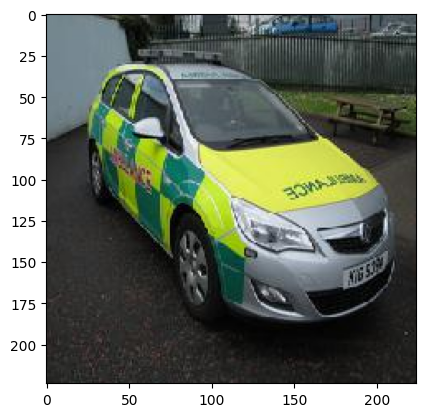

In [15]:
plt.imshow(image)

In [16]:
image.shape


(224, 224, 3)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
image_gen = ImageDataGenerator(
            rotation_range=20,# specifies the rotation to be 20%
            width_shift_range=0.1, # specifies the width shift of 10%
            height_shift_range=0.1,# specifies the height shift of 10%
            shear_range=0.20, # crops part of the image
            zoom_range=0.20, # #zooms the image by 20%
            fill_mode='nearest', # fills using the nearest pixel
            horizontal_flip=True, # Secifies the horizontal flip
            rescale=1/255 # scales the image
)

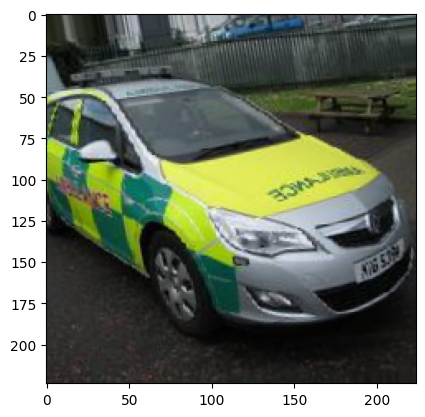

In [19]:
plt.imshow(image_gen.random_transform(image))

In [20]:
train_df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Emergency_Vehicles/train.csv")
test_df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Emergency_Vehicles/test.csv")

In [21]:
test_df

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg
...,...
701,674.jpg
702,1027.jpg
703,447.jpg
704,2176.jpg


In [22]:
train_df


,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0
...,...,...
1641,1638.jpg,0
1642,1095.jpg,0
1643,1130.jpg,0
1644,1294.jpg,0


In [23]:
if 'emergency_or_not' in train_df.columns:
    train_df['emergency_or_not'] = train_df['emergency_or_not'].astype(str)

if 'emergency_or_not' in test_df.columns:
    test_df['emergency_or_not'] = test_df['emergency_or_not'].astype(str)

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB


In [25]:
train_generator=image_gen.flow_from_dataframe(dataframe=train_df[:1150], # specify the dataset used for trainin
 directory=train_dir, # specify the path to the directory
 x_col='image_names', # specify the names of the images
 y_col='emergency_or_not', # specifies the class labels
 class_mode='binary', # specifies the kind of classification
 target_size=(224,224), # specifies the dimension to resize the im
 batch_size=50# defines the batch size
 )
validation_generator=image_gen.flow_from_dataframe(dataframe=train_df[1150:], # specify the dataset used for tr
 directory=train_dir, # specify the path to the directory
 x_col='image_names', # specify the names of the images
 y_col='emergency_or_not', # specifies the class labels
 class_mode='binary', # specifies the kind of classification
 target_size=(224,224), # specifies the dimension to resize the im
 batch_size=50 # defines the batch size
 )

Found 1150 validated image filenames belonging to 2 classes.
Found 496 validated image filenames belonging to 2 classes.


In [26]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 110, 110, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │       1,081,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,101,221 (4.20 MB)

 Trainable params: 1,101,157 (4.20 MB)

 Non-trainable params: 64 (256.00 B)

In [29]:
history=model.fit(train_generator,epochs = 30,validation_data = validation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 417s 18s/step - accuracy: 0.6217 - loss: 0.6928 - val_accuracy: 0.6069 - val_loss: 0.6643
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - accuracy: 0.7386 - loss: 0.5279 - val_accuracy: 0.6069 - val_loss: 0.6594
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.7369 - loss: 0.5228 - val_accuracy: 0.6754 - val_loss: 0.6706
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - accuracy: 0.7671 - loss: 0.4823 - val_accuracy: 0.6673 - val_loss: 0.6487
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.7959 - loss: 0.4418 - val_accuracy: 0.6190 - val_loss: 0.6374
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.7996 - loss: 0.4262 - val_accuracy: 0.6351 - val_loss: 0.6414
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.8180 - loss: 0.4039 - val_accuracy: 0.6673 - val_loss: 0.6445
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.8171 - loss: 0.4067 - val_accuracy: 0.6069 - 

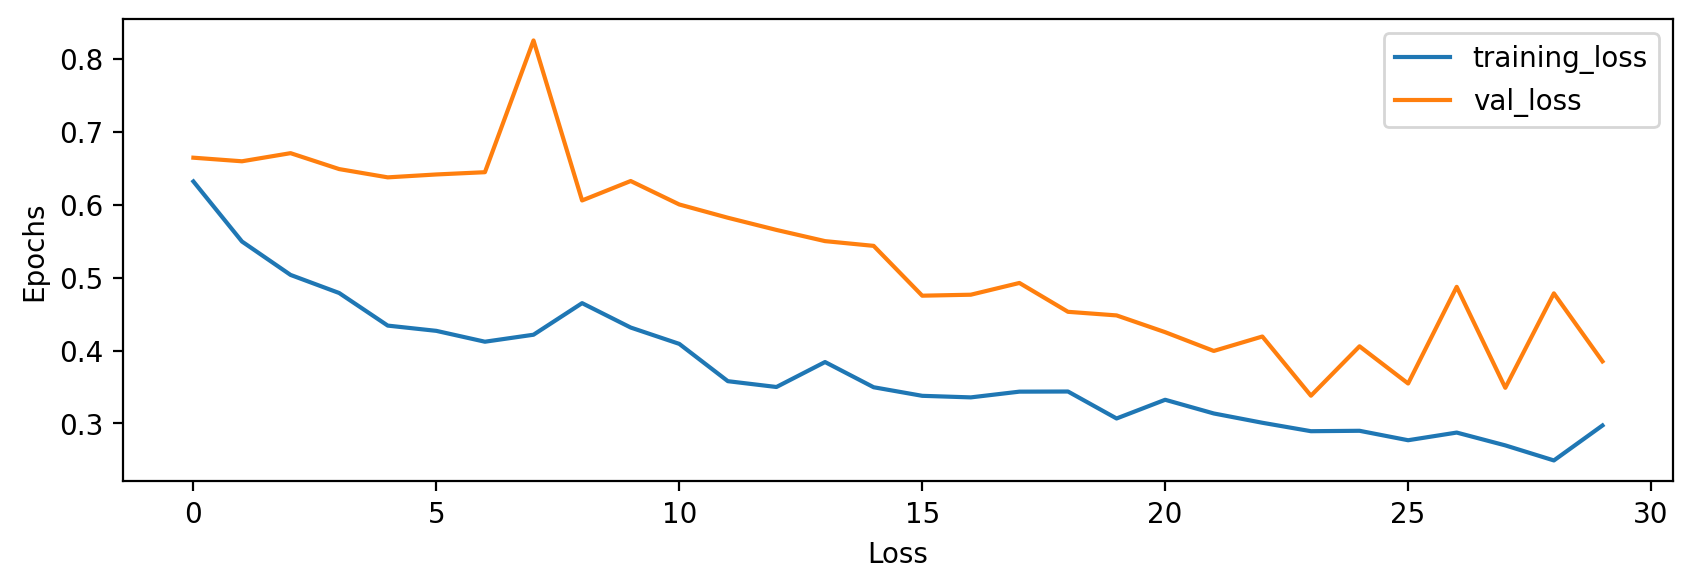

In [30]:
history_df = pd.DataFrame(history.history)
plt.figure(dpi=200, figsize = (10,3))
plt.plot(history_df['loss'],
 label='training_loss')
plt.plot(history_df['val_loss'],
 label='val_loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

In [47]:
test_df.index

RangeIndex(start=0, stop=706, step=1)

In [49]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

test_dir_image = []
base_path = "/content/drive/My Drive/Colab Notebooks/Emergency_Vehicles/test/"

for i in tqdm(test_df.index):
    img_path = os.path.join(base_path, test_df['image_names'][i])  # Use safer path joining

    # Check if the file exists
    if not os.path.exists(img_path):
        print(f"Warning: {img_path} not found, skipping...")
        continue  # Skip missing files

    img = Image.open(img_path).convert('RGB')  # Load image using PIL
    img = img.resize((224, 224))  # Resize image
    img = np.array(img)  # Convert to NumPy array
    test_dir_image.append(img)

test = np.array(test_dir_image)


 12%|█▏        | 88/706 [00:00<00:01, 456.04it/s]

 19%|█▉        | 134/706 [00:00<00:01, 417.63it/s]

 32%|███▏      | 223/706 [00:00<00:01, 417.38it/s]

 43%|████▎     | 307/706 [00:00<00:00, 401.10it/s]

 55%|█████▍    | 385/706 [00:01<00:00, 338.86it/s]

 65%|██████▍   | 456/706 [00:01<00:00, 337.30it/s]

 75%|███████▍  | 529/706 [00:01<00:00, 326.72it/s]

 80%|███████▉  | 563/706 [00:01<00:00, 323.97it/s]

 90%|████████▉ | 632/706 [00:01<00:00, 321.09it/s]

100%|██████████| 706/706 [00:01<00:00, 355.36it/s]


In [50]:
pred = model.predict(test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 584ms/step


In [51]:
num_ = np.floor(pred)

In [58]:
print(f"Expected submission rows: {len(submission)}")
print(f"Actual predictions count: {len(num_)}")
import os

# Get the expected test images from submission.csv
expected_images = set(submission['image_names'])

# Get the actual processed images
processed_images = set(test_df['image_names'])

# Find which images are missing
missing_images = expected_images - processed_images
extra_images = processed_images - expected_images

print(f"Missing images: {missing_images}")
print(f"Extra images: {extra_images}")
for img_name in missing_images:
    img_path = f"/content/drive/My Drive/Colab Notebooks/Emergency_Vehicles/test/{img_name}"
    if not os.path.exists(img_path):
        print(f"File missing: {img_path}")
test_df = test_df.set_index('image_names').loc[submission['image_names']].reset_index()
if len(num_) < len(submission):
    print(f"Adding {len(submission) - len(num_)} dummy predictions to match submission length.")
    num_ = list(num_) + [0] * (len(submission) - len(num_))  # Pad with 0s (or the most common class)
elif len(num_) > len(submission):
    print(f"Trimming {len(num_) - len(submission)} excess predictions.")
    num_ = num_[:len(submission)]


Expected submission rows: 706
Actual predictions count: 329
Missing images: set()
Extra images: set()
Adding 377 dummy predictions to match submission length.


In [59]:
submission['emergency_or_not'] = num_
submission.to_csv('/content/drive/My Drive/Colab Notebooks/Emergency_Vehicles/sample_submission.csv', index=False)
print("✅ Submission file saved successfully!")


✅ Submission file saved successfully!


In [60]:
submission.to_csv('submission29.csv', index = False)

In [61]:
submission.head(5)

,image_names,emergency_or_not
0,1960.jpg,[0.0]
1,668.jpg,[1.0]
2,2082.jpg,[0.0]
3,808.jpg,[1.0]
4,1907.jpg,[0.0]


In [62]:
from tensorflow.keras.models import load_model
model.save('vehicle.h5')
model_vechile = load_model(('vehicle.h5'),custom_objects={'KerasLayer':hub.KerasLayer})